In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import torch.optim as optim
import math

device = torch.device('cuda')
device_ids=[0,1]

def process_data(X,device=device):
    temp_x=[i[0][0].unsqueeze_(0) for i in X]#升维再导入
    data_x=torch.cat(temp_x).reshape(-1,28,28)#加上通道数
    data_y=torch.tensor([i[1] for i in X])
    return data_x.to(device),data_y.to(device)

trans = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="/data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/data", train=False, transform=trans, download=True)

(train_x0,train_y0)=process_data(mnist_train,device="cuda:1")
(test_x0,test_y0)=process_data(mnist_test,device="cuda:1")

100%|██████████| 26421880/26421880 [00:00<00:00, 117379010.13it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4413522.14it/s]

Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 58480204.40it/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9371648.00it/s]


Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



In [3]:
train_y=torch.nn.functional.one_hot(train_y0, num_classes=10).to(torch.float32)

patch_size=4
train_x=train_x0.unsqueeze(1)

patches=nn.functional.unfold(train_x,kernel_size=(patch_size,patch_size),stride=patch_size).transpose(-1,-2)
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        super(MultiHeadAttention, self).__init__() #初始化 nn.Module
        assert d_model % num_heads == 0 # 能够等分 h 为头数目
        self.num_heads=num_heads
        self.d_model=d_model
        self.d_k = d_model // num_heads # key 通过类似CNN的多通道机制进行分离
        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, d_model).to(device)
        self.W_v = nn.Linear(d_model, d_model).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) # 表示对倒数第二个和最后一个维度进行转置。
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9) # 传入mask
        attn_probs = torch.softmax(attn_scores, dim=-1) #对dk进行
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, _ = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)#先分成两个维度 不破坏原始数据结构
        # (batch_size, self.h, seq_length, self.d_k)

    def combine_heads(self, x):
        batch_size, _, seq_length, _ = x.size() #split 的逆向操作
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        #.contiguous() 可以确保张量在内存中是按照顺序排列的，以便后续的操作。

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff).to(device)
        self.fc2 = nn.Linear(d_ff, d_model).to(device)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model) # position ecoding 矩阵，对小于最大长度所有序列计算
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1) #插入维度 batch_size
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0)) #它会与模型的参数一起被 PyTorch 的 state_dict() 保存和加载
         # 同时加了一维 batch_size self.pe 是一个形状为 (1, max_seq_length, d_model) 的张量

    def forward(self, x):
        return x + self.pe[:, :x.size(1)] # 利用广播机制相加 x.size(1) 说明超出seq_length 的部分不加

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model,device=device) #最后一个维度
        self.norm2 = nn.LayerNorm(d_model,device=device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output)) # 残差连接
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class ViT(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout,cls):
        super(ViT, self).__init__()
        self.ec=EncoderLayer(d_model, num_heads, d_ff, dropout).to('cuda:0')
        self.ec1=EncoderLayer(d_model, num_heads, d_ff, dropout).to('cuda:0')
        self.ec2=EncoderLayer(d_model, num_heads, d_ff, dropout).to('cuda:0')
        self.ec3=EncoderLayer(d_model, num_heads, d_ff, dropout).to('cuda:1')
        self.ec4=EncoderLayer(d_model, num_heads, d_ff, dropout).to('cuda:1')
        self.cls=cls.to('cuda:0')
        self.fc=nn.Linear(d_model, 128).to('cuda:1')
        self.fc2=nn.Linear(128, 10).to('cuda:1')
        self.sf = nn.Softmax(dim=1).to('cuda:1')

    def forward(self,x):
        ec_output0=self.ec2(self.ec1(self.ec(torch.cat((cls,x.to("cuda:0")),dim=1))))
        ec_output=self.ec4(self.ec3(ec_output0.to("cuda:1")))[:,0,:]
        return self.sf(self.fc2(self.fc(ec_output)))


train_x=train_x0.unsqueeze(1) # 最后一维为通道数
train_x=nn.functional.unfold(train_x,kernel_size=(patch_size,patch_size),stride=patch_size).transpose(-1,-2).to(device)

cls=torch.randn(60000,1,16).to(device)
vit=ViT(16,2,64,0.1,cls)
# vit= nn.DataParallel(vit,device_ids=device_ids)
# vit.to(device)
vit.train()

ViT(
  (ec): EncoderLayer(
    (self_attn): MultiHeadAttention(
      (W_q): Linear(in_features=16, out_features=16, bias=True)
      (W_k): Linear(in_features=16, out_features=16, bias=True)
      (W_v): Linear(in_features=16, out_features=16, bias=True)
      (W_o): Linear(in_features=16, out_features=16, bias=True)
    )
    (feed_forward): PositionWiseFeedForward(
      (fc1): Linear(in_features=16, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=16, bias=True)
      (relu): ReLU()
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ec1): EncoderLayer(
    (self_attn): MultiHeadAttention(
      (W_q): Linear(in_features=16, out_features=16, bias=True)
      (W_k): Linear(in_features=16, out_features=16, bias=True)
      (W_v): Linear(in_features=16, out_features=16, bias=True)
      (W_o): Linear(in_features=16, out_f

In [4]:
loss_list=[]
criterion = nn.CrossEntropyLoss()
# param=torch.load('/kaggle/working/mnist.params')
# vit.load_state_dict(param)
optimizer = optim.Adam(vit.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)


for epoch in range(300):
    optimizer.zero_grad()
    output = vit(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
    loss_list.append(loss.item())

optimizer = optim.Adam(vit.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

for epoch in range(1000):
    optimizer.zero_grad()
    output = vit(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
    loss_list.append(loss.item())
    
# optimizer = optim.Adam(vit.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# for epoch in range(100):
#     optimizer.zero_grad()
#     output = vit(train_x)
#     loss = criterion(output, train_y)
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
#     loss_list.append(loss.item())

Epoch: 1, Loss: 2.302617311477661
Epoch: 2, Loss: 2.3002283573150635
Epoch: 3, Loss: 2.2929179668426514
Epoch: 4, Loss: 2.272113084793091
Epoch: 5, Loss: 2.2460567951202393
Epoch: 6, Loss: 2.2430148124694824
Epoch: 7, Loss: 2.240355968475342
Epoch: 8, Loss: 2.2343459129333496
Epoch: 9, Loss: 2.233771324157715
Epoch: 10, Loss: 2.2220051288604736
Epoch: 11, Loss: 2.2155678272247314
Epoch: 12, Loss: 2.213329792022705
Epoch: 13, Loss: 2.21610951423645
Epoch: 14, Loss: 2.1971776485443115
Epoch: 15, Loss: 2.210327386856079
Epoch: 16, Loss: 2.194064140319824
Epoch: 17, Loss: 2.1889307498931885
Epoch: 18, Loss: 2.1878581047058105
Epoch: 19, Loss: 2.173678159713745
Epoch: 20, Loss: 2.181079864501953
Epoch: 21, Loss: 2.1640243530273438
Epoch: 22, Loss: 2.1724190711975098
Epoch: 23, Loss: 2.1540911197662354
Epoch: 24, Loss: 2.1585235595703125
Epoch: 25, Loss: 2.1424648761749268
Epoch: 26, Loss: 2.1367039680480957
Epoch: 27, Loss: 2.1290009021759033
Epoch: 28, Loss: 2.1076836585998535
Epoch: 29, L

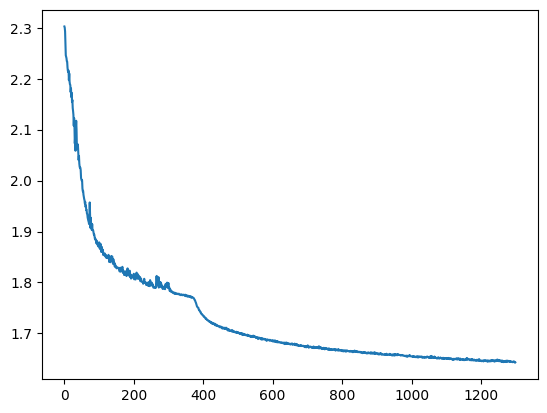

In [5]:
import pandas as pd 
pd.Series(loss_list).plot()
torch.save(vit.state_dict(), "/kaggle/working/mnist.params")

In [6]:
total_params = sum(p.numel() for p in vit.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 19866


In [11]:
param=torch.load('/kaggle/working/mnist.params')
vit.load_state_dict(param)
_, result = torch.max(vit(train_x), dim=1)
len=60000
num=0
for index,value in enumerate(train_y0):
    if(value==result[index]):
        
        num+=1
num/len

0.8169